# Setup
Imports

In [151]:
import matplotlib.pyplot as plt
import numpy as np
from time import sleep
from os.path import basename, exists

# Agent

The plant in which inhabits a given ecosystem.

### Attributes:
- **genes**: the parameters used to passdown to the offspring
- **loc**: (x,y) location on grid of object
- **age**: number of steps plant has been alive, incremented each step
- **size**: 'vertical height' of plant (used to determine survival when fighting for resources)
- **type**: The different species of plant.
- **colour**: The colour of the plant.
- **friends**: Other plants which the given plant can possibly coexist with.
- **lifespan**: Age at which the plant will die.
- **resilience**: Constant used to determine survival when fighting for limited resources
- **growth_rate**: The amount in which size will be increased by every step
- **reproduction_area**: The area around the plant in which new plants can be created
- **reproduction_rate**: For any of the given surrounding neighbours, in an area defined by the reproduction_area, if unoccupied, the chance that a new plant of the same type will appear

In [152]:
class Plant:

    def __init__(self, location, params):
        
        self.genes = params
        self.loc = tuple(location)
        self.age = 0
        self.size = 0
        self.type = params["type"]
        self.colour = params["colour"]
        self.friends = params.get("friends", [])
        self.lifespan = int(np.random.uniform(params["min_lifespan"], params["max_lifespan"]))
        self.resilience = np.random.uniform(params["min_resilience"], params["max_resilience"])
        self.growth_rate = np.random.uniform(params["min_growth_rate"], params["max_growth_rate"])
        self.reproduction_rate = np.random.uniform(params["min_reproduction_rate"], params["max_reproduction_rate"])
        self.reproduction_area = params["reproduction_area"]

    def step(self):
        self.age += 1
        self.size = self.size + self.growth_rate
        return 0
    
    def reproduce(self, ecosystem):
        # return a list of plants of the same type to be input into the eco
        empty_neighbours = ecosystem.get_empty_neighbours(self)
        if(len(empty_neighbours) == 0):
            return []
        offspring = []
        for empty_neighbour in empty_neighbours:
            random_zero_to_one = np.random.random()
            if random_zero_to_one < self.reproduction_rate:
                # generate a new agent
                temp_plant = Plant(empty_neighbour, self.genes)
                offspring.append(temp_plant)
        return offspring
    
    def is_old(self):
        return self.age >= self.lifespan

## Plant Tracker

In [153]:
class PlantTracker:
    def __init__(self):
        self.plant_populations = {}
        self.plant_deaths = {}
        self.plant_lifespans = {}

    def update_populations(self, agents, time_step):
        self.current_population = {}
        for agent in agents:
            # Add populations
            if agent.type in self.current_population:
                self.current_population[agent.type] += 1
            else:
                self.current_population[agent.type] = 1

        for plant_type in self.current_population:
            if plant_type in self.plant_populations:
                self.plant_populations[plant_type].append((time_step, self.current_population[plant_type]))
            else:
                self.plant_populations[plant_type] = [(time_step,self.current_population[plant_type])]

    def get_population_data(self, plant_type):
        times = []
        counts = []
        for step in self.plant_populations[plant_type]: 
            times.append(step[0])
            counts.append(step[1])
        return times, counts
    
    def update_death(self, agent: Plant, time_step: int):
        self.plant_deaths[agent.type][time_step] += 1

    def get_death_data(self, plant_type):
        times = []
        deaths = []
        for time_step in self.plant_deaths[plant_type]:
            times.append(time_step)
            deaths.append(self.plant_deaths[plant_type][time_step])
        return times, deaths
    
    def update_lifespans(self, agents: list, time_step: int):
        for agent in agents:
            if agent.type not in self.plant_lifespans:
                self.plant_lifespans[agent.type] = {}
            if time_step not in self.plant_lifespans[agent.type]:
                self.plant_lifespans[agent.type][time_step] = []
            self.plant_lifespans[agent.type][time_step].append(agent.age)

    def get_lifespan_data(self, plant_type):
        times = []
        lifespans = []
        for time_step in self.plant_lifespans[plant_type]:
            times.append(time_step)
            lifespans.append(np.mean(self.plant_lifespans[plant_type][time_step]))
        return times, lifespans
    
        

# Environment

The environment in which the plants will be housed.

### Attributes:
- **n**: Number of rows and columns for the grid.
- **params**: Dictionary of parameters.
- **agents**: List of plant agents in the environment.
- **tracker**: Tracker object to get plant counts.
- **time_step**: Time step count.
- **occupied**: List of locations occupied by plants.
- **resource_scarcity** : Constant used to determine competition between plants.
- **flora_types**: List of different types of flora in the environment.
- **colours**: List of colours representing different flora types.
- **array**: 2D grid representing the environment, initialized with zeros.
- **just_died**: List to track locations where plants have just died to prevent immediate replacement.

In [154]:
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
from IPython.display import clear_output

class Ecosystem():
    """Represents a given ecoystem."""

    def __init__(self, n: int, resource_scarcity: int):
        """Initializes the attributes.
        n: number of rows and columns
        params: dictionary of parameters
        """

        self.n = n
        self.agents = []
        self.occupied = []
        self.tracker = PlantTracker()
        self.time_step = 0
        self.resource_scarcity = resource_scarcity
        self.flora_types = []
        self.colours = ["white"]
        self.array = np.zeros((n,n))
        self.just_died = []

    def make_agents(self, agents: dict[Plant, str]):
        """
        Populate the ecoystem with flora.
        This function takes given, specified
        plants populates the ecosystem with them. 
        """
        for current_agent in agents:
            self.add_plant(current_agent)

    def add_plant(self, agent: Plant):
        """Add a given plant to the ecosystem"""
        if not agent.loc in self.just_died:
            self.agents.append(agent)
            self.occupied.append(agent.loc)

    def introduce_plant(self,agent: Plant):
        # Introduce an entirley new plant to the ecosystem
        if agent.type not in self.flora_types:
            self.flora_types.append(agent.type)
        if agent.colour not in self.colours:
            self.colours.append(agent.colour)
        self.add_plant(agent)
        return
    
    def remove_plant(self, agent: Plant):
        """ Remove a plant from the ecosystem"""
        self.agents.remove(agent)
        self.occupied.remove(agent.loc)
        self.just_died.append(agent.loc)

    def get_neighbours(self, agent: Plant, radii: int):
        loc_row = agent.loc[0]
        loc_column = agent.loc[1]

        row_start = max(0, loc_row-radii)
        row_end = min(self.array.shape[0], loc_row+(radii+1))
        
        col_start = max(0, loc_column-radii)
        col_end = min(self.array.shape[1], loc_column+(radii+1))

        neighbours = []
        for row in range(row_start, row_end):
            for col in range(col_start, col_end):
                # Exclude the current plant itself
                if not (row == loc_row and col == loc_column):
                    neighbours.append((row,col))
         
        return neighbours

    def get_empty_neighbours(self, agent: Plant):
        # Define the range for rows and columns, ensuring the indices don't go out of bounds

        neighbours = self.get_neighbours(agent, agent.reproduction_area)
        empty_neighbours = []

        for neighbour in neighbours:
            if not (neighbour in self.occupied):
                empty_neighbours.append(neighbour)

        return empty_neighbours
    
    def get_competing_neighbours(self, central_agent: Plant):
        neighbours = self.get_neighbours(central_agent,1)
        occupied_neighbours = []

        for neighbour in neighbours:
            if (neighbour in self.occupied):
                for competing_agent in self.agents:
                    if competing_agent.loc == neighbour:
                        occupied_neighbours.append(competing_agent)
        return occupied_neighbours
    
    def check_competition(self, agent: Plant):
        occupied_neighbours = self.get_competing_neighbours(agent)
        if not occupied_neighbours is None:
            for neighbour in occupied_neighbours:
                random_zero_to_one = np.random.random()
                friend_buff = 0
                for friend in agent.friends:
                    if friend[0] == neighbour.type:
                        friend_buff = friend[1]
                if random_zero_to_one + friend_buff < self.resource_scarcity:
                    if agent.size + agent.resilience > neighbour.size + neighbour.resilience:
                        self.remove_plant(neighbour)
                        self.tracker.update_death(neighbour, self.time_step)

                    else:
                        self.remove_plant(agent)
                        self.tracker.update_death(agent, self.time_step)
                        return
        

    def step(self):
        """Executes one time step."""
        self.time_step += 1
        for type in self.flora_types:
            if type in self.tracker.plant_deaths:
                self.tracker.plant_deaths[type].update({self.time_step: 0})
            else:
                self.tracker.plant_deaths[type] = {self.time_step: 0}
        self.just_died = [] #Reset this each step


        # loop through the agents in random order
        random_order = np.random.permutation(self.agents)
        for agent in random_order:
            if agent in self.agents: #might have been removed midway
                agent.step()

                # If the agent plant is too old, remove from the ecosystem
                if agent.is_old():
                    #self.array[agent.loc] = 3 #Death colour (TEMP) (should be red)
                    self.remove_plant(agent)
                    

                else:
                    # Generate plant(s) next to the current one
                    self.check_competition(agent)

                    offspring = agent.reproduce(self)
                    if len(offspring) != 0:
                        for new_plant in offspring:
                            self.add_plant(new_plant)

        
        self.tracker.update_populations(self.agents, self.time_step)
        self.tracker.update_lifespans(self.agents, self.time_step)
        return len(self.agents)

    def draw(self):
        """Draws the ecosystem as a cellular automata grid."""
        # Clear the previous figure
        plt.clf()
        
        cmap = ListedColormap(self.colours)
        bound = []
        for i in range(len(self.flora_types) + 2):
            bound.append(i)
        norm = BoundaryNorm(bound, cmap.N)
        # Update the array based on the positions of the agents
        for agent in self.agents:
            for index, type in enumerate(self.flora_types):
                if agent.type == type:
                        self.array[agent.loc] = index + 1


        # Draw the ecosystem grid
        plt.imshow(self.array, cmap=cmap, norm=norm, origin='lower')
        plt.gca().axes.get_xaxis().set_visible(False)  # Hide x-axis
        plt.gca().axes.get_yaxis().set_visible(False)   
        legend_patches = []
        for index, flora in enumerate(self.flora_types):
            color = self.colours[index + 1]
            patch = mpatches.Patch(color=color, label=flora)
            legend_patches.append(patch)
        
        plt.legend(handles=legend_patches, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=3)
        plt.title(f"Ecosystem Cellular Automata Visualization \n ")
        plt.show()


        # Reset the array to zero for the next step
        self.array.fill(0)

    def animate(self, frames):
        """Animate the automaton.
        
        frames: number of frames to draw
        """
        clear_output()

        plt.figure()
        try:
            for i in range(frames-1):
                self.step()
            self.draw()
            plt.show()
        except KeyboardInterrupt:
            pass

    def get_coords(self):
        """Gets the coordinates of the agents.

        Transforms from (row, col) to (x, y).

        returns: tuple of sequences, (xs, ys)
        """
        rows, cols = np.transpose([agent.loc for agent in self.agents])
        xs = cols + 0.5
        ys = rows + 0.5
        return xs, ys

# Real Life Emulations

In [155]:
# Code to graph data
import matplotlib.pyplot as pyplot

def plot_populations(ecosystem: Ecosystem, step_limit: int):
    plant_tracker = ecosystem.tracker
    for plant_type in plant_tracker.plant_populations:
        times, counts = plant_tracker.get_population_data(plant_type)
        colour = ecosystem.colours[ecosystem.flora_types.index(plant_type) + 1]
        pyplot.plot(times, counts, label=plant_type, color=colour)

    pyplot.xlabel('Time Steps')
    pyplot.ylabel('Number of Plants')
    pyplot.title('Plant Population Over Time')

    # Adding legend
    pyplot.legend()

    pyplot.xlim(left=0,right=step_limit)
    pyplot.ylim(bottom=0)

def plot_deaths(ecosystem: Ecosystem, step_limit: int):
    plant_tracker = ecosystem.tracker
    for plant_type in plant_tracker.plant_deaths:
        times, deaths = plant_tracker.get_death_data(plant_type)
        colour = ecosystem.colours[ecosystem.flora_types.index(plant_type) + 1]
        pyplot.plot(times, deaths, label=plant_type, color=colour)

    pyplot.xlabel('Time Steps')
    pyplot.ylabel('Number of Deaths')
    pyplot.title('Plant Competition deaths Over Time')

    # Adding legend
    pyplot.legend()

    pyplot.xlim(left=0,right=step_limit)
    pyplot.ylim(bottom=0)

def plot_ages(ecosystem: Ecosystem, step_limit: int):
    plant_tracker = ecosystem.tracker
    for plant_type in plant_tracker.plant_deaths:
        times, ages = plant_tracker.get_lifespan_data(plant_type)
        colour = ecosystem.colours[ecosystem.flora_types.index(plant_type) + 1]
        pyplot.plot(times, ages, label=plant_type, color=colour)

    pyplot.xlabel('Time Steps')
    pyplot.ylabel('Average Plant Age')
    pyplot.title('Average Plant Age Over Time')

    # Adding legend
    pyplot.legend()

    pyplot.xlim(left=0,right=step_limit)
    pyplot.ylim(bottom=0)


    

## Drummonds Wattle vs Eastern States Wattle:

In this visualisation, we aimed to examine what happens when two plants with differnt growth archetypes collide. The real world model we aimed to emulate was the competition between the Drummonds Wattle and Eastern state wattles. Cootamundra wattle (Acacia baileyana), Sydney golden wattle (A. longifolia) and Flinders Range wattle (A. iteaphylla) are the invasive wattles, and we have grouped them together as they have the same issue. The eastern state wattles usually have low germination rates due to seed eating insects, however in WA, we lack these insects, so they reproduce prolifically. Furthermore, wattles are nitrogen fixers, which means that it produces essential resources for many exotic grasses, causing more invasive species to proliferate, out competing the native flora, which in this case, is our own  Drummonds Wattle.

In [215]:
# Example parameters for the plant
drummond_params = {
    "type": "Drummonds Wattle",
    "colour": "red",
    "friends": [("Drummonds Wattle", 0.7)],
    "min_lifespan": 4,
    "max_lifespan": 8,
    "min_resilience": 0.4,
    "max_resilience": 0.7,
    "min_growth_rate": 0.1,
    "max_growth_rate": 0.3,
    "min_reproduction_rate": 0.1,
    "max_reproduction_rate": 0.2,
    "reproduction_area": 1}

eastern_params = {
    "type": "Eastern State Wattle",
    "colour": "yellow",
    "friends": [("Foreign Grass", 0.4)],
    "min_lifespan": 3,
    "max_lifespan": 6,
    "min_resilience": 0.4,
    "max_resilience": 0.5,
    "min_growth_rate": 0.3,
    "max_growth_rate": 0.8,
    "min_reproduction_rate": 0.05,
    "max_reproduction_rate": 0.2,
    "reproduction_area": 3
}


grass_params = {
    "type": "Foreign Grass",
    "colour": "green",
    "friends": [("Eastern State Wattle", 0.3)],
    "min_lifespan": 2,
    "max_lifespan": 3,
    "min_resilience": 0.2,
    "max_resilience": 0.3,
    "min_growth_rate": 0.3,
    "max_growth_rate": 0.8,
    "min_reproduction_rate": 0.4,
    "max_reproduction_rate": 0.5,
    "reproduction_area": 2
}

drummond = Plant((30, 30), drummond_params)
eastern_wattle = Plant((6, 6), eastern_params)
grass = Plant((2, 2), grass_params)

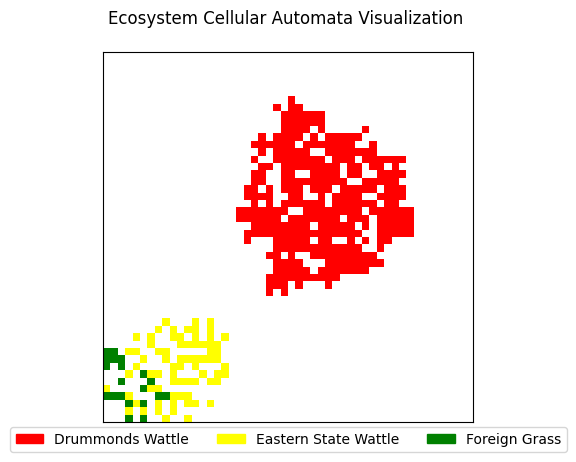

In [216]:
wa_bush = Ecosystem(50, 0.5)
wa_bush.introduce_plant(drummond)
wa_bush.animate(20)
wa_bush.introduce_plant(eastern_wattle)
wa_bush.introduce_plant(grass)
wa_bush.animate(5)


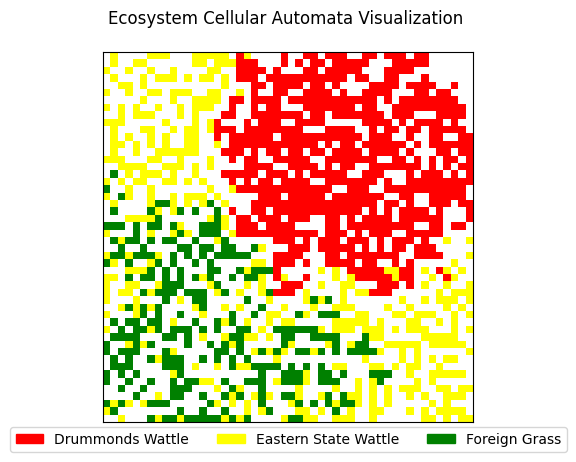

In [217]:

wa_bush.animate(25)

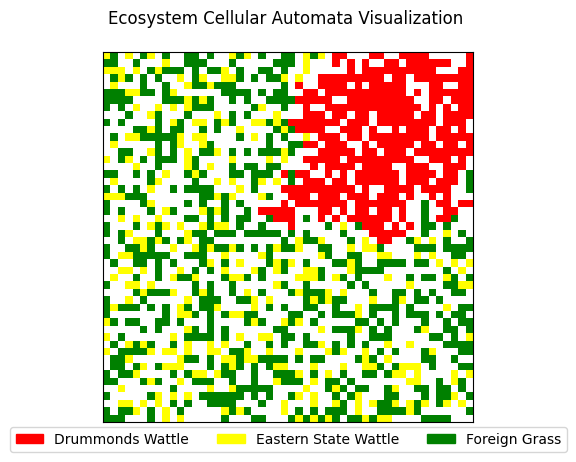

In [218]:
wa_bush.animate(50)

### Results


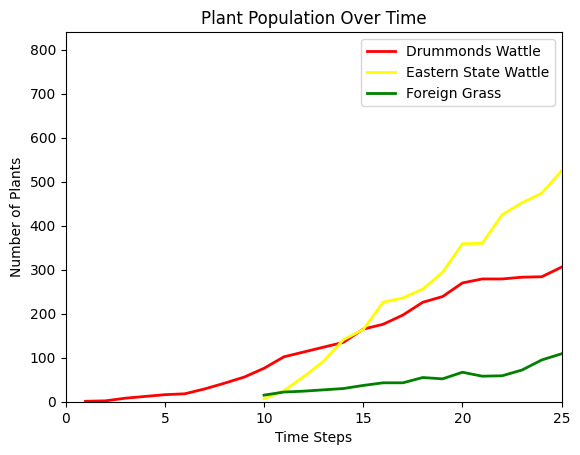

In [160]:

plot_populations(wa_bush, step_limit=100)

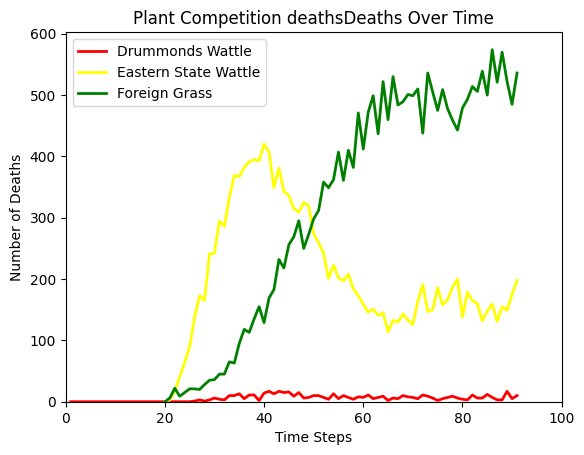

In [231]:
plot_deaths(wa_bush, step_limit=100)

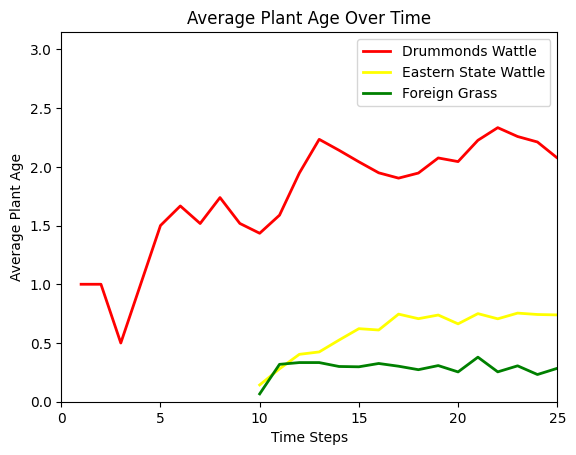

In [162]:
plot_ages(wa_bush, step_limit=100)

## DW vs ESW, with the modelling of seed eating insects

We can see that the native drummonds clearly gets overrun wattles. We modelled to see what happens if the wattles, lose their spreading ability, e.g. the seed eating insects are introduced.

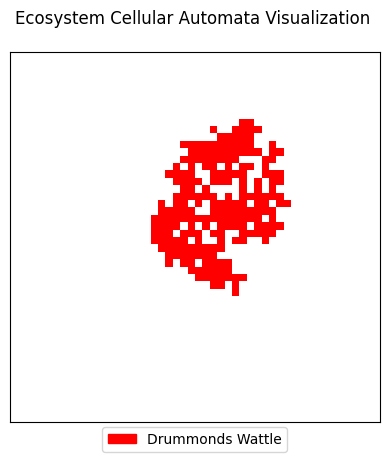

In [206]:
eastern_params["reproduction_area"] = 1
eastern_params["min_reproduction_rate"] = 0.2
eastern_params["max_reproduction_rate"] = 0.3
eastern_params["friends"] = []
grass_params["reproduction_area"] = 1
grass_params["min_reproduction_rate"] = 0.3
grass_params["max_reproduction_rate"] = 0.4
grass_params["friends"] = [("Eastern State Wattle", 0.1)]


drummond_altered = Plant((25, 25), drummond_params)
wattle_altered = Plant((10, 10), eastern_params)
grass_altered = Plant((2, 2), grass_params)
altered_bush = Ecosystem(50, 0.5)
altered_bush.introduce_plant(drummond_altered)
altered_bush.animate(10)

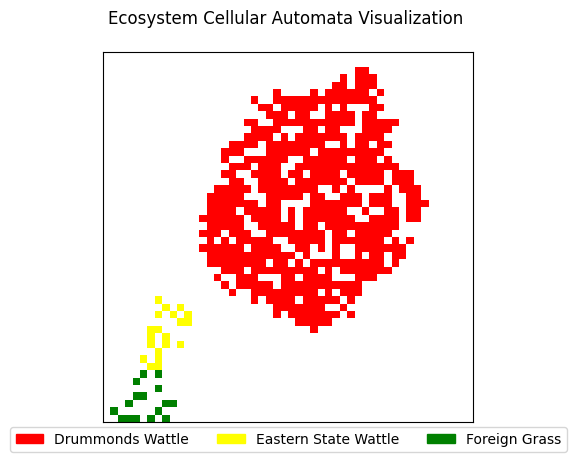

In [207]:
altered_bush.introduce_plant(wattle_altered)
altered_bush.introduce_plant(grass_altered)
altered_bush.animate(10)

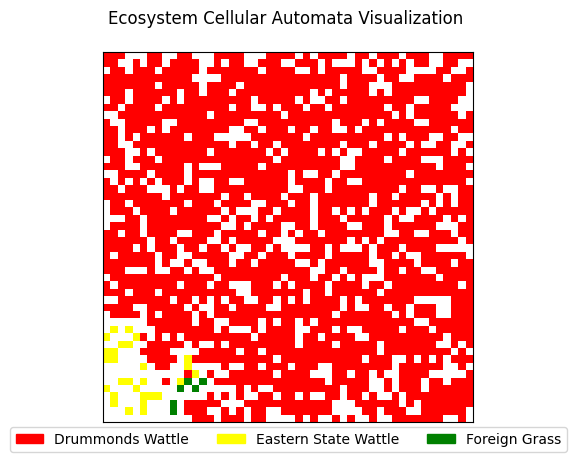

In [209]:
altered_bush.animate(20)

### Altered results

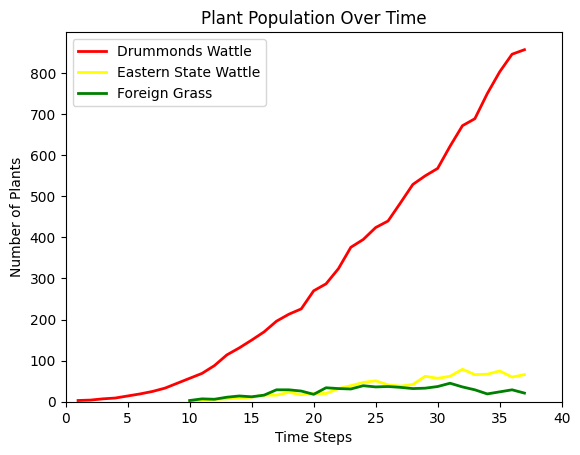

In [166]:
plot_populations(altered_bush, step_limit=40)

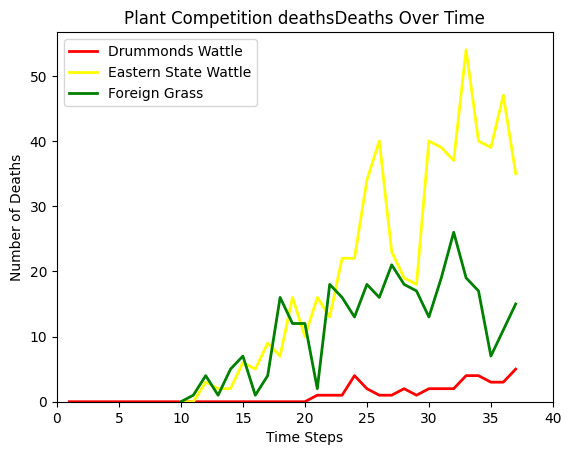

In [167]:
plot_deaths(altered_bush, step_limit=40)

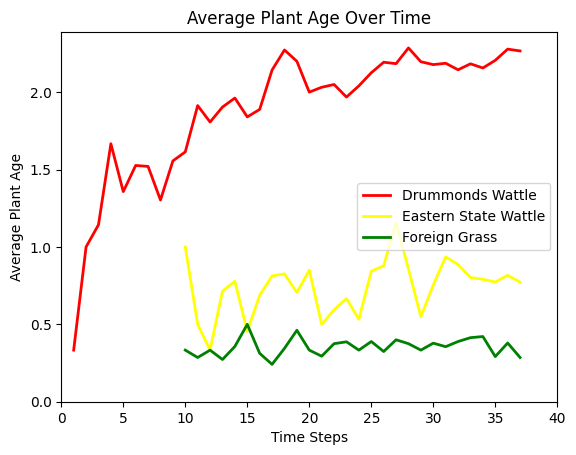

In [168]:
plot_ages(altered_bush, step_limit=40)

## Eucalyptus vs Fynbos

It is important to understand that despite the biodiverse nature of western australia, many australian plants are invasive species overseas. In this case, we are visualising the effects of the introduction of the famous australian eucalyptus tree,


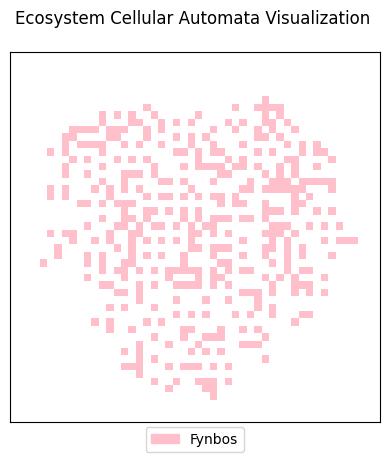

In [169]:
# Example parameters for the plant
eucalyptus_params = {
    "type": "Eucalyptus",
    "colour": "orange",
    "min_lifespan": 5,
    "max_lifespan": 50,
    "min_resilience": 0.4,
    "max_resilience": 0.7,
    "min_growth_rate": 0.3,
    "max_growth_rate": 0.5,
    "min_reproduction_rate": 0.05,
    "max_reproduction_rate": 0.1,
    "reproduction_area": 2}

fynbos_params = {
    "type": "Fynbos",
    "colour": "pink",
    "min_lifespan": 5,
    "max_lifespan": 25,
    "min_resilience": 0.2,
    "max_resilience": 0.4,
    "min_growth_rate": 0.1,
    "max_growth_rate": 0.3,
    "min_reproduction_rate": 0.05,
    "max_reproduction_rate": 0.1,
    "reproduction_area": 2}

african_fynbosgroves = Ecosystem(50, 0.5)
eucalypt = Plant((2, 2), eucalyptus_params)
fynbos = Plant((25, 25), fynbos_params)
african_fynbosgroves.introduce_plant(fynbos)
african_fynbosgroves.animate(20)

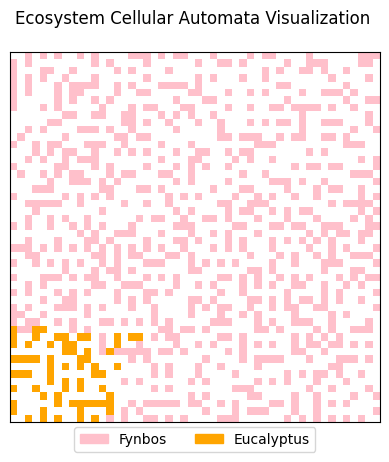

In [170]:
african_fynbosgroves.introduce_plant(eucalypt)
african_fynbosgroves.animate(50)

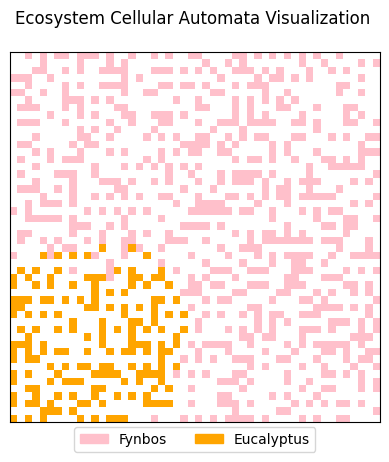

In [171]:
african_fynbosgroves.animate(50)

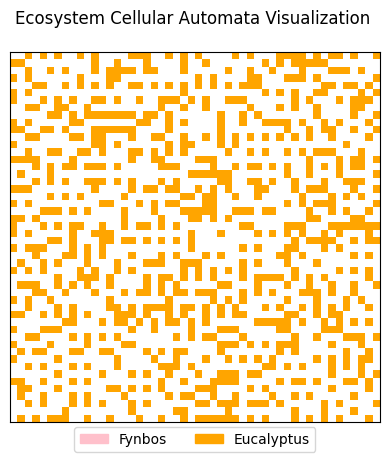

In [172]:
african_fynbosgroves.animate(200)

### Results

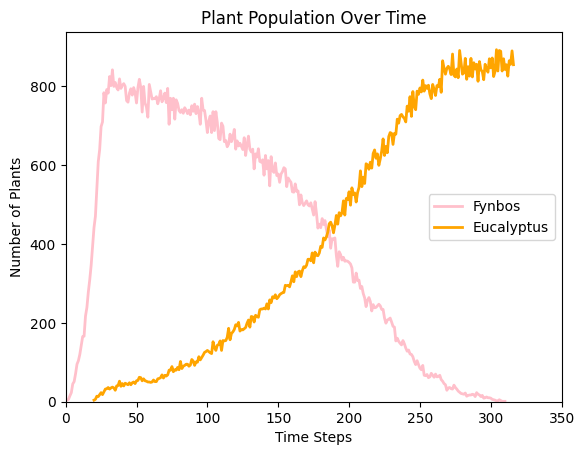

In [173]:
plot_populations( african_fynbosgroves, step_limit=350)

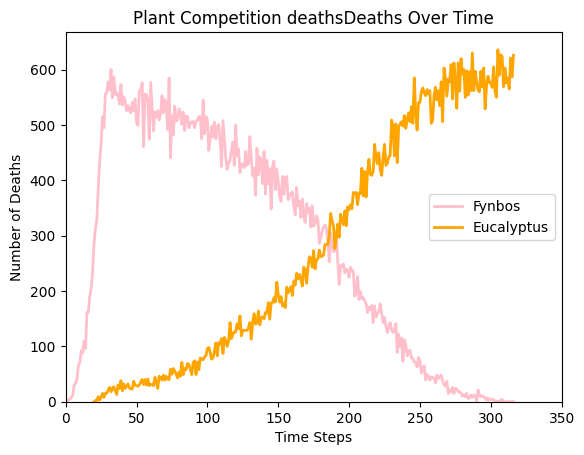

In [174]:
plot_deaths(african_fynbosgroves, step_limit=350)

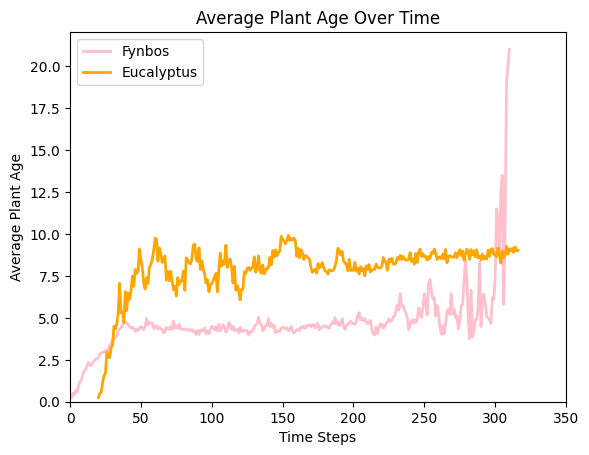

In [175]:
plot_ages(african_fynbosgroves, step_limit=350)

## Scalesia vs Hillraspberry

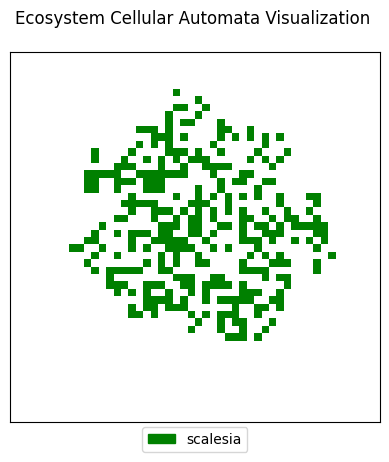

In [228]:
scalesia_params = {
    "type": "scalesia",
    "colour": "green",
    "friends": [("scalesia", 0.2)],
    "min_lifespan": 5,
    "max_lifespan": 50,
    "min_resilience": 0.4,
    "max_resilience": 0.7,
    "min_growth_rate": 0.3,
    "max_growth_rate": 0.5,
    "min_reproduction_rate": 0.1,
    "max_reproduction_rate": 0.2,
    "reproduction_area": 1}

hillraspberry_params = {
    "type": "raspberry",
    "colour": "red",
    "friends": [("raspberry", 0.4)],
    "min_lifespan": 2,
    "max_lifespan": 5,
    "min_resilience": 0.4,
    "max_resilience": 0.7,
    "min_growth_rate": 0.1,
    "max_growth_rate": 0.3,
    "min_reproduction_rate": 0.1,
    "max_reproduction_rate": 0.2,
    "reproduction_area": 3}

galapagos = Ecosystem(50, 0.5)
scalesia = Plant((25, 25), scalesia_params)
hillraspberry= Plant((5, 5), hillraspberry_params)
galapagos.introduce_plant(scalesia)
galapagos.animate(40)

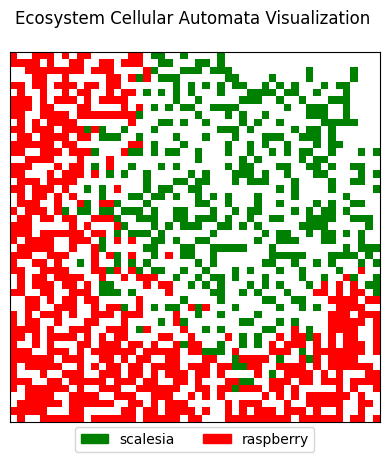

In [229]:
galapagos.introduce_plant(hillraspberry)
galapagos.animate(20)

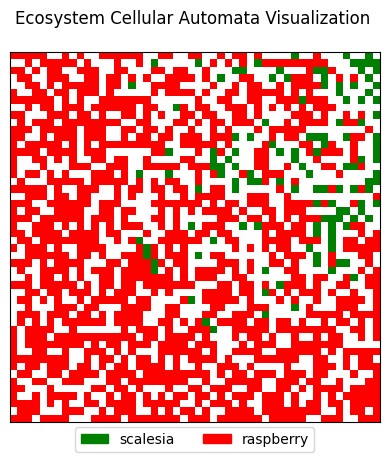

In [230]:
galapagos.animate(40)

### Results

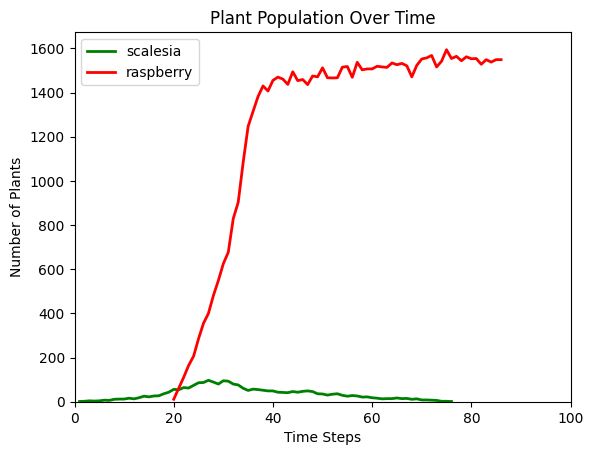

In [180]:
plot_populations(galapagos, step_limit=100)

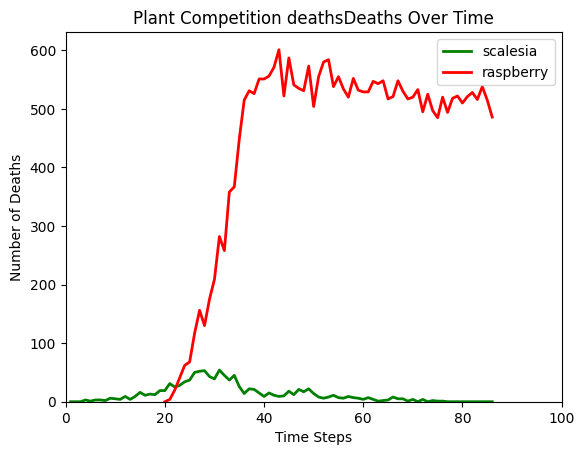

In [181]:
plot_deaths(galapagos, step_limit=100)

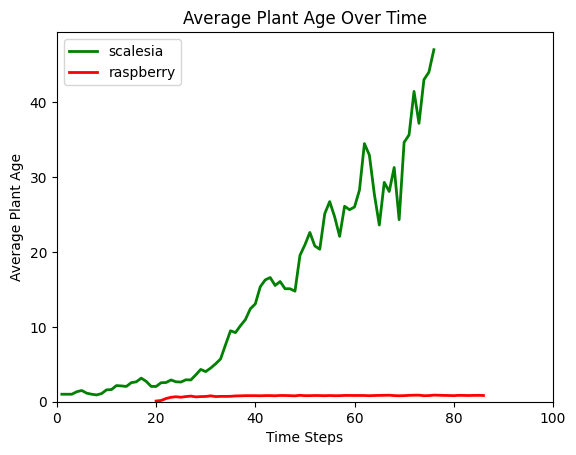

In [182]:
plot_ages(galapagos, step_limit=100)